In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

##  The Novel Coronavirus: Data Science and Machine Learning Visualizations

This is the site where I pull the recent `.csv` files: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

This notebook uses the confimed, deaths, and recovered database

In [2]:
!ls

COVID19 Visualizations.ipynb        graphs_by_countries_legend
COVID19_worldwide.png               time_series_2019-ncov-Confirmed.csv
Icon?                               time_series_2019-ncov-Deaths.csv
graphs_by_countries                 time_series_2019-ncov-Recovered.csv


In [3]:
#Load the CSV files. Please make sure to pull the latest files from the website
COVID19_confirmed = pd.read_csv("time_series_2019-ncov-Confirmed.csv")
COVID19_deaths = pd.read_csv("time_series_2019-ncov-Deaths.csv")
COVID19_recovered = pd.read_csv("time_series_2019-ncov-Recovered.csv")

In [4]:
COVID19_confirmed.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,82,114,147,177,212,272,322,411,599,599.0
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,773,839,825,878,889,924,963,1007,1086,1086.0
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,212,226,243,266,313,345,385,432,455,455.0
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,2,2.0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,238,428,566,673,790,900,1030,1183,1306,1306.0
5,British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,...,64,73,103,103,186,231,271,424,424,424.0
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,112,134,171,210,267,307,353,436,533,533.0
7,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,49,57,71,94,121,121,121,229,296,296.0
8,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,46,61,68,78,94,144,184,221,221,221.0
9,NaN,Cambodia,11.5500,104.9167,0,0,0,0,0,1,...,7,7,7,33,35,37,51,53,84,84.0


In [5]:
#Lat and Long data could be used later or map visualization
COVID19_confirmed = COVID19_confirmed.drop(['Lat', 'Long'], axis=1)
COVID19_deaths = COVID19_deaths.drop(['Lat', 'Long'], axis=1)
COVID19_recovered = COVID19_recovered.drop(['Lat', 'Long'], axis=1)

I don't know how to filter out the NaN for smaller countries for no provinces/states, so I split the data into two sections between big countries and small countries helper functions. Everything should work smoothly.

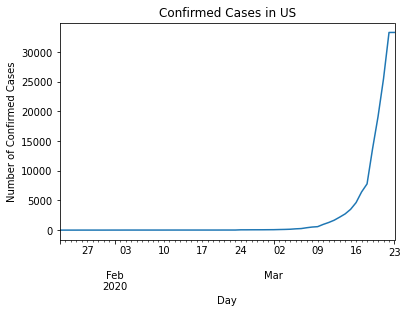

In [6]:
def small_country(country_name, data):
    country = data
    country = country.pivot_table(index=['Country/Region'])
    country.columns = pd.to_datetime(country.columns)
    country = country.groupby(level=[0], sort=False).sum()
    country = country.loc[country_name]
    country = country.sort_index().plot()
    
    if data.equals(COVID19_confirmed):
        dataType = "Confirmed Cases"
    elif data.equals(COVID19_recovered):
        dataType = "Recovered"
    elif data.equals(COVID19_deaths):
        dataType = "Deaths"
    
    #Labelings
    country.set_ylabel("Number of " + dataType)
    country.set_xlabel("Day")
    country.set_title(dataType + " in " + country_name)
    return country

def big_country(country_name, data):
    country = data
    country = country.pivot_table(index=['Country/Region', 'Province/State'])
    country.columns = pd.to_datetime(country.columns)
    country = country.groupby(level=[0], sort=False).sum()
    country = country.loc[country_name]
    country = country.sort_index().plot()

    if data.equals(COVID19_confirmed):
        dataType = "Confirmed Cases"
    elif data.equals(COVID19_recovered):
        dataType = "Recovered"    
    elif data.equals(COVID19_deaths):
        dataType = "Deaths"
    
    #Labelings
    country.set_ylabel("Number of " + dataType)
    country.set_xlabel("Day")
    country.set_title(dataType + " in " + country_name)
    return country

def country(country_name, data):
    big_countries = ['Australia', 'Canada', 'China', 'Cruise Ship', 
                       'Denmark', 'France', 'Netherlands', 'US', 'United Kingdom']
    if country_name in big_countries:
        return big_country(country_name, data)
    else:
        return small_country(country_name, data)
    
country("US", COVID19_confirmed)

In [7]:
#Saves each graph for each country. Takes a long time to run and save (around 5 minutes)
def updateAllCountryGraphs():
    all_countries = list(COVID19_confirmed['Country/Region'])
    all_countries = list(dict.fromkeys(all_countries))
    data = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]
    
    for Country in all_countries:
        for dataType in data:
            country(Country, dataType[0])
            plt.savefig("graphs_by_countries/" + Country + "_" + dataType[1] + ".png")
            plt.tight_layout()
            plt.clf()
            
updateAllCountryGraphs()

<Figure size 432x288 with 0 Axes>

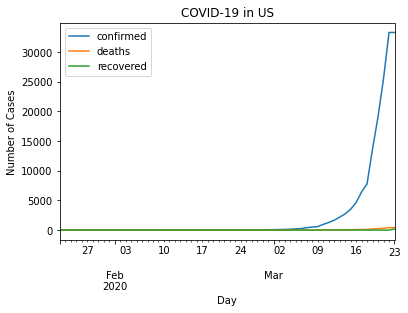

In [8]:
dataset = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]

def small_country_legend(country_name):
    for data in dataset:
        country = data[0]
        country = country.pivot_table(index=['Country/Region'])
        country.columns = pd.to_datetime(country.columns)
        country = country.groupby(level=[0], sort=False).sum()
        country = country.loc[country_name]
        country = country.sort_index().plot(label=data[1])
    
    #Labelings
    country.set_ylabel("Number of Cases")
    country.set_xlabel("Day")
    country.set_title("COVID-19 in " + country_name)
    country.legend()
    return country 

def big_country_legend(country_name):
    for data in dataset:
        country = data[0]
        country = country.pivot_table(index=['Country/Region', 'Province/State'])
        country.columns = pd.to_datetime(country.columns)
        country = country.groupby(level=[0], sort=False).sum()
        country = country.loc[country_name]
        country = country.sort_index().plot(label=data[1])

    #Labelings
    country.set_ylabel("Number of Cases")
    country.set_xlabel("Day")
    country.set_title("COVID-19 in " + country_name)
    country.legend()
    return country 

def country_legend(country_name):
    big_countries = ['Australia', 'Canada', 'China', 'Cruise Ship', 
                       'Denmark', 'France', 'Netherlands', 'US', 'United Kingdom']
    if country_name in big_countries:
        return big_country_legend(country_name)
    else:
        return small_country_legend(country_name)
    
country_legend('US')

In [9]:
def updateAllCountryGraphsLegend():
    all_countries = list(COVID19_confirmed['Country/Region'])
    all_countries = list(dict.fromkeys(all_countries))
    
    for Country in all_countries:
        country_legend(Country)
        plt.savefig("graphs_by_countries_legend/" + Country + "_all.png")
        plt.tight_layout()
        plt.clf()
            
updateAllCountryGraphsLegend()

<Figure size 432x288 with 0 Axes>

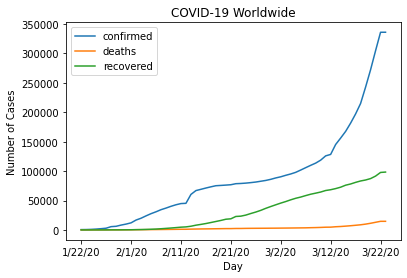

In [10]:
allCountries_confirmed = COVID19_confirmed.drop(['Country/Region', 'Province/State'], axis=1).sum()
allCountries_deaths = COVID19_deaths.drop(['Country/Region', 'Province/State'], axis=1).sum()
allCountries_recovered = COVID19_recovered.drop(['Country/Region', 'Province/State'], axis=1).sum()

def allCountries():
    world = allCountries_confirmed.plot(label="confirmed")
    world = allCountries_deaths.plot(label="deaths")
    world = allCountries_recovered.plot(label="recovered")
    
    #Labelings
    world.set_ylabel("Number of Cases")
    world.set_xlabel("Day")
    world.set_title("COVID-19 Worldwide")
    world.legend()
    plt.savefig("COVID19_worldwide")
    return world

allCountries()